# Spiral

The goal is to display how the model is learning to draw a spiral, given the input coordintes $x$ and $y$.

A GoMLX coded version of [TensorFlow's Neural Network Playground](https://playground.tensorflow.org/).

## Imports

In [198]:
import (
    "math"
    
    "github.com/gomlx/gomlx/backends"
    . "github.com/gomlx/gomlx/pkg/core/graph"
    "github.com/gomlx/gomlx/pkg/core/shapes"
    "github.com/gomlx/gomlx/pkg/core/tensors"
    "github.com/gomlx/gomlx/pkg/ml/context"
    "github.com/gomlx/gomlx/pkg/ml/datasets"
    "github.com/gomlx/gomlx/pkg/ml/train"
    "github.com/gomlx/gomlx/pkg/ml/train/losses"
    "github.com/gomlx/gomlx/pkg/ml/layers/activations"
    "github.com/gomlx/gomlx/pkg/ml/layers/fnn"
    "github.com/gomlx/gomlx/pkg/ml/train/losses"
    "github.com/gomlx/gomlx/pkg/ml/train/optimizers"
    "github.com/gomlx/gomlx/pkg/core/dtypes"
    "github.com/janpfeifer/gonb/gonbui"
    "github.com/janpfeifer/gonb/cache"
    "github.com/chai2010/webp"

    // Include default backends
    _ "github.com/gomlx/gomlx/backends/default"
)

// Backend used everywhere. Default will use GPU if available, otherwise CPU.
var Backend = backends.MustNew()

// Makes sure there is a valid reference to `graph` package imported inline.
var _ = Add

// Define how we want to fail in case of errors.
func init_must() {
    must.M = func(err error) {
        if err != nil {
            log.Fatal("Error:\n%+v\n", err)
        }
    }
}


## Plotting

We are plotting functions $f(x,y) \text{ where } x, y \in [-1, 1]$. The output of $f(x,y) \in [0, 1]$ represents a degree of grayness 0.0 representing white and 1.0 representing black.

The functions are given GoMLX functions, that take as input one array shaped `[batch_size, 2]` (`batch_size` pairs of $(x, y)$).


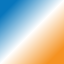

In [189]:
// PlotFn is the graph function accepted by the plot functions: [batch, 2] -> [batch]. The output values should be bewteen -1 and +1.
type PlotFn func (ctx *context.Context, xys *Node) *Node 

// PlotToImg returns an image of size "size x size", with the plotted function, that can be displayed or composed.
// The context can be nil, if the function doesn't use any variables.
func PlotToImg(ctx *context.Context, fn PlotFn, size int) image.Image {
    if ctx == nil {
        ctx = context.New()
    }
    ctx = ctx.Reuse()  // When plotting, we shouldn't be creating new variables. This way it will fail if function is not yet trained.
    values := context.MustExecOnce(Backend, ctx, func (ctx *context.Context, g *Graph) *Node {
        xys := imgXYsForSize(g, size)
        output := fn(ctx, xys)
        return ClipScalar(output, -1, 1)  // Clip to the values allowed.
    })
    negColor  := color.NRGBA{245, 147, 34, 255}
    zeroColor := color.NRGBA{255, 255, 255, 255}
    posColor  := color.NRGBA{8, 119, 189, 255}
    lerp := func(c1, c2 color.NRGBA, t float32) color.NRGBA {
    	return color.NRGBA{
    		R: uint8(float32(c1.R) + (float32(c2.R)-float32(c1.R))*t),
    		G: uint8(float32(c1.G) + (float32(c2.G)-float32(c1.G))*t),
    		B: uint8(float32(c1.B) + (float32(c2.B)-float32(c1.B))*t),
       		A: uint8(float32(c1.A) + (float32(c2.A)-float32(c1.A))*t),
    	}
    }
    img := image.NewNRGBA(image.Rect(0, 0, size, size))
    tensors.ConstFlatData[float32](values, func (data []float32) {
        for y := range size {
            for x := range size {
                val := data[y * size + x]
            	var c color.NRGBA
            	if val < 0 {
            		c = lerp(posColor, zeroColor, val+1)
            	} else {
            		c = lerp(zeroColor, negColor, val)
            	}
            	img.SetNRGBA(x, y, c)
            }
        }
    })
    return img
}

// imgXYsForSize creates all combination of (x, y) for an image of size (size x size), where $x,y \in [-1, 1]$.
// The output is shaped [batchSize, 2], where batchSize = size * size.
func imgXYsForSize(g *Graph, size int) *Node {
    xs := Iota(g, shapes.Make(dtypes.Float32, size, size), 1) // -> 0, size-1
    xs = AddScalar(DivScalar(xs, float64(size-1)/2.0), -1)  // -> -1.0, 1.0
    ys := Iota(g, shapes.Make(dtypes.Float32, size, size), 0)
    ys = AddScalar(DivScalar(ys, float64(size-1)/2.0), -1)  // -> -1.0, 1.0
    xys := Stack([]*Node{xs, ys}, -1)
    xys = Reshape(xys, size*size, 2)  // Contract width and height axes into a "batch_size" axis.
    return xys
}

// Plot displays an image generated from the given function.
func Plot(ctx *context.Context, fn PlotFn, size int) {
    img := PlotToImg(ctx, fn, size)
    imgSrc := must.M1(gonbui.EmbedImageAsPNGSrc(img))
    gonbui.DisplayHTML(fmt.Sprintf("<img src=%q/>", imgSrc))
}

%%
// Small test of a gradient function on the x,y diagonal.
Plot(nil, func (_ *context.Context, xys *Node) *Node {
    value := ReduceAndKeep(xys, ReduceSum, -1)  // x+y -> -2.0 to 2.0
    return DivScalar(value, 1.5)  // Values will be clipped to [-1, +1]
}, 64)


## Spiral Figure

This is the shape we are trying to learn. The `Spiral()` function returns the labels for the given XY input pairs.


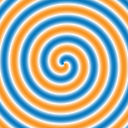

In [201]:
var SpiralAngularSpeed = float32(20)

// Spiral returns values [-1, +1] for the given (X,Y) pairs (xy shaped [batch, 2])
// that represent a spiral.
func Spiral(xy *Node) *Node {
    radius := L2Norm(xy, -1)
    x := Slice(xy, AxisRange(), AxisElem(0))
    y := Slice(xy, AxisRange(), AxisElem(1))
    angle := Atan2(x, y)
    phase := Add(angle, MulScalar(radius, SpiralAngularSpeed))
    return Sin(phase)
}

%%
// Small test of a gradient function on the x,y diagonal.
Plot(nil, func (_ *context.Context, xys *Node) *Node { return Spiral(xys) }, 128)

## Training Loop and FNN model

A small convenient training loop that every second updates the generated image from the model.

In [203]:
// DisplayProgress display the images in a sequence, with the attached labels below.
// It returns the HTML for that.
func DisplayProgress(images, imageLabels []string) string {
    parts := make([]string, 0, len(images)+len(imageLabels)+3)
    parts = append(parts, "<table><tr>")
    for _, img := range images {
        parts = append(parts, fmt.Sprintf("  <td>%s</td>", img))
    }
    parts = append(parts, "</tr><tr>")
    for _, label := range imageLabels {
        parts = append(parts, fmt.Sprintf("  <td>%s</td>", label))
    }
    parts = append(parts, "</tr></table")
    return strings.Join(parts, "\n")
}

In [233]:
var BatchSize = 128

func Train(ctx *context.Context, modelFn PlotFn, numSteps int) {
    // trainModelFn with the signature the Trainer likes.
    trainModelFn := func(ctx *context.Context, _ any, inputs []*graph.Node) []*graph.Node {
		return []*graph.Node{modelFn(ctx, inputs[0])}
	}

    // Random batch generator, using Spiral for ground truth.
    batchGenerator := context.MustNewExec(Backend, ctx, func (ctx *context.Context, g *Graph) (xys *Node, labels *Node) {
        xys = ctx.RandomUniform(g, shapes.Make(dtypes.Float32, BatchSize, 2)) // -> 0.0 <= xys < 1.0
        xys = AddScalar(MulScalar(xys, 2), -1) // -> -1 <= xys < 1
        labels = Spiral(xys)
        return xys, labels
    })

    // Create a Trainer, and loop over numSteps.
	trainer := train.NewTrainer(Backend, ctx, trainModelFn,
		losses.MeanSquaredError,
		optimizers.Adam().Done(),
		nil, nil) // no metrics for this simple example
    var images, imageLabels []string
    uiID := gonbui.UniqueID()
    for step := range numSteps {
        xys, labels := batchGenerator.MustExec2()
        metrics := must.M1(trainer.TrainStep(nil, []*tensors.Tensor{xys}, []*tensors.Tensor{labels}))
		if step% (numSteps/10) == 0 || step == numSteps-1 {
			img := must.M1(gonbui.EmbedImageAsPNGSrc(PlotToImg(ctx, modelFn, 64)))
            images = append(images, fmt.Sprintf("<img src=\"%s\"/>", img))
            imageLabels = append(
                imageLabels, fmt.Sprintf("Loss=%.4f", metrics[0].Value().(float32)))
            gonbui.UpdateHTML(uiID, DisplayProgress(images, imageLabels))
		}
	}
    
    // Plot final result.
    gonbui.UpdateHTML(uiID, "")
    gonbui.DisplayHTML(DisplayProgress(images, imageLabels))
    Plot(ctx, modelFn, 128)
}

## ModelFNN 

Our baseline model, small enough so it can't learn the function.

,,,,,,,,,,
Loss=0.8205,Loss=0.5182,Loss=0.4872,Loss=0.4365,Loss=0.4665,Loss=0.4624,Loss=0.3807,Loss=0.3613,Loss=0.3547,Loss=0.2916,Loss=0.3502

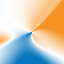
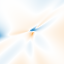
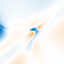
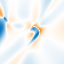
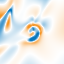
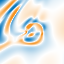
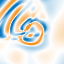
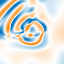
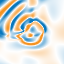
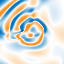
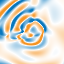


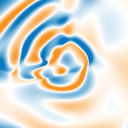

In [223]:
// ModelFNN has 3 hidden layers of 6 nodes each, residual connection and layer-norm.
func ModelFNN(ctx *context.Context, xys *Node) *Node {
    return fnn.New(ctx, xys, 1). 
        NumHiddenLayers(3, 6).
        Activation(activations.TypeSilu).
        Normalization("layer").
        Residual(true).
        Done()
}

%%
Train(context.New(), ModelFNN, 100_000)

## Model Radius Angle

Same parameters as ModelFNN, but feeding the angle and radius

,,,,,,,,,,
Loss=1.2325,Loss=0.5349,Loss=0.4466,Loss=0.3591,Loss=0.1572,Loss=0.1220,Loss=0.0887,Loss=0.0636,Loss=0.0891,Loss=0.0792,Loss=0.0412

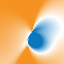
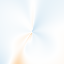
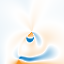
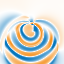
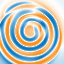
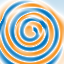
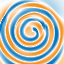
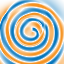
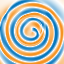
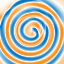
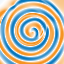


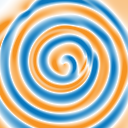

In [234]:
// ModelRadiusAngle
func ModelRadiusAngle(ctx *context.Context, xys *Node) *Node {
    radius := L2Norm(xys, -1)
    x := Slice(xys, AxisRange(), AxisElem(0))
    y := Slice(xys, AxisRange(), AxisElem(1))
    angle := Atan2(x, y)
    inputs := Concatenate([]*Node{radius, Sin(angle), Cos(angle)}, -1) 
    return fnn.New(ctx, inputs, 1). 
        NumHiddenLayers(3, 6).
        Activation(activations.TypeSilu).
        Normalization("layer").
        Residual(true).
        Done()
}

%%
Train(context.New(), ModelRadiusAngle, 100_000)

## Side-Task Model

Below is a comparison of training with the side-task and without it. 

The results are unstable: if we repeat enough sometimes either can do well or badly. But on average with the side-task enabled
the model does significantly better.

In [246]:
func ModelSideTask(ctx *context.Context, xys *Node) *Node {
    hiddenNodes := 6
    middleLayer := fnn.New(ctx.In("head"), xys, hiddenNodes). 
        NumHiddenLayers(2, hiddenNodes).
        Activation(activations.TypeSilu).
        Normalization("layer").
        Residual(true).
        Done()
    g := xys.Graph()
    useSideTask := context.GetParamOr(ctx, "side_task", false)
    if useSideTask && ctx.IsTraining(g) {
        // Add extra loss (side-task): the targets are the radius, sin() and cos().
        targetRadius := L2Norm(xys, -1)
        x := Slice(xys, AxisRange(), AxisElem(0)) 
        y := Slice(xys, AxisRange(), AxisElem(1))
        adjustedRadius := MaxScalar(targetRadius, 1e-4)
        targetSin := Div(y, adjustedRadius)
        targetCos := Div(x, adjustedRadius)

        // Force the first values middleLayer to predict the radius, sin(), and cos(),
        // by adding extra losses (they are added to the final MSE loss).
        radius := Slice(middleLayer, AxisRange(), AxisElem(0)) // middleLayer[:,0]
        sin := Slice(middleLayer, AxisRange(), AxisElem(1)) // middleLayer[:,1]
        cos := Slice(middleLayer, AxisRange(), AxisElem(2)) // middleLayer[:,2]
        train.AddLoss(ctx, losses.MeanSquaredError([]*Node{radius}, []*Node{targetRadius}))
        train.AddLoss(ctx, losses.MeanSquaredError([]*Node{sin}, []*Node{targetSin}))
        train.AddLoss(ctx, losses.MeanSquaredError([]*Node{cos}, []*Node{targetCos}))
    }
    return fnn.New(ctx.In("tail"), middleLayer, 1). 
        NumHiddenLayers(1, hiddenNodes).
        Activation(activations.TypeSilu).
        Normalization("layer").
        Residual(true).
        Done()
}

### Side-Task Disabled

,,,,,,,,,,
Loss=14.6928,Loss=0.5036,Loss=0.4818,Loss=0.4557,Loss=0.3844,Loss=0.4684,Loss=0.3925,Loss=0.3426,Loss=0.3045,Loss=0.3534,Loss=0.2980

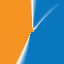
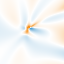
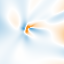
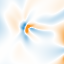
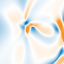
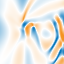
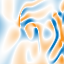
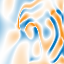
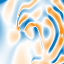
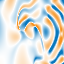
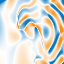


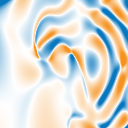

In [243]:
%%
ctx := context.New()
ctx.SetParam("side_task", false)
Train(ctx, ModelSideTask, 100_000)

### Side-Task Enabled

,,,,,,,,,,
Loss=16.8543,Loss=0.5549,Loss=0.4340,Loss=0.3914,Loss=0.2262,Loss=0.1955,Loss=0.2160,Loss=0.2899,Loss=0.2552,Loss=0.2182,Loss=0.2011

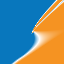
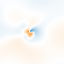
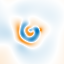
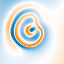
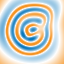
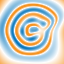
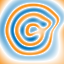
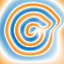
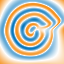
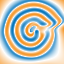
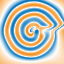


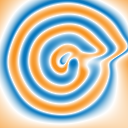

In [245]:
%%
ctx := context.New()
ctx.SetParam("side_task", true)
Train(ctx, ModelSideTask, 100_000)